In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
import random
from dateutil.parser import parse
from scipy import signal
from scipy.interpolate import interp1d
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf, grangercausalitytests
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
%matplotlib inline

np.random.seed(42)


%matplotlib inline

data = pd.read_csv('https://raw.githubusercontent.com/myungjun-kim-beep/econ2005/master/team-project/2020-1%EC%A1%B0-Stock%20market%20and%20Housing%20market/Rawdata.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        151 non-null    object 
 1   KOSPI        151 non-null    float64
 2   Price_Seoul  151 non-null    float64
 3   Homeloan     151 non-null    float64
 4   Call_rate    151 non-null    float64
 5   M2           151 non-null    float64
 6   Export       151 non-null    float64
 7   Sentiment    151 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.6+ KB


<span style = "font-size:2em; font-weight:bolder"> DATA </span>

In [3]:
data.describe()

,KOSPI,Price_Seoul,Homeloan,Call_rate,M2,Export,Sentiment
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,1946.260397,86.678609,143740.114570,2.245099,2062.955629,18.985430,54.237020
std,283.207890,6.822394,27712.859613,1.031501,477.508221,2.903134,34.914707
min,1073.950000,78.640000,106294.400000,0.480000,1269.500000,9.900000,8.120000
25%,1849.095000,82.035000,124694.250000,1.490000,1678.700000,17.600000,23.565000
50%,1979.850000,84.140000,128903.200000,2.000000,1965.000000,19.500000,48.630000
75%,2083.065000,87.570000,169437.250000,2.750000,2452.300000,20.850000,80.925000
max,2533.510000,104.640000,202582.300000,5.220000,3077.300000,26.000000,164.490000


In [4]:
data.corr()

,KOSPI,Price_Seoul,Homeloan,Call_rate,M2,Export,Sentiment
KOSPI,1.000000,0.411322,0.678259,-0.448195,0.695196,0.814393,0.432811
Price_Seoul,0.411322,1.000000,0.877398,-0.511720,0.819980,0.222924,0.496427
Homeloan,0.678259,0.877398,1.000000,-0.723967,0.982793,0.457770,0.620553
Call_rate,-0.448195,-0.511720,-0.723967,1.000000,-0.755579,-0.236417,-0.428281
M2,0.695196,0.819980,0.982793,-0.755579,1.000000,0.513718,0.583477
Export,0.814393,0.222924,0.457770,-0.236417,0.513718,1.000000,0.149283
Sentiment,0.432811,0.496427,0.620553,-0.428281,0.583477,0.149283,1.000000


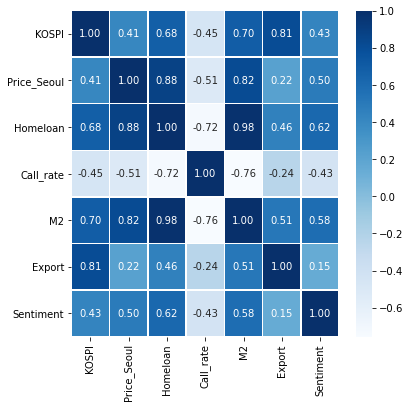

In [5]:
plt.figure(figsize=(6,6))
sns.heatmap(data = data.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [6]:
data.head()

,Month,KOSPI,Price_Seoul,Homeloan,Call_rate,M2,Export,Sentiment
0,07-Dec,1903.99,78.64,107469.2,4.99,1269.5,15.4,59.52
1,08-Jan,1732.29,79.19,107433.5,4.99,1286.4,13.5,74.43
2,08-Feb,1689.53,79.72,106294.4,4.97,1309.2,15.6,80.63
3,08-Mar,1651.15,80.87,106393.8,4.97,1324.0,15.7,96.05
4,08-Apr,1776.58,82.20,107235.2,4.99,1339.4,16.5,95.65


<span style = "font-size:2em; font-weight:bolder"> Unit root test </span>

In [7]:
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
    
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [8]:
df_1 = data[["KOSPI"]]
df_1 = df_1.dropna()

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_1, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.791247
P-Value                   0.384816
# Lags Used               2.000000
# Observations Used     148.000000
Critical Value (1%)      -3.475325
Critical Value (5%)      -2.881275
Critical Value (10%)     -2.577293
dtype: float64
Is the time series stationary? False


In [9]:
df_2 = data[["Price_Seoul"]]
df_2 = df_2.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_2, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        1.058839
P-Value                   0.994850
# Lags Used               1.000000
# Observations Used     149.000000
Critical Value (1%)      -3.475018
Critical Value (5%)      -2.881141
Critical Value (10%)     -2.577221
dtype: float64
Is the time series stationary? False


In [10]:
df_3 = data[["Call_rate"]]
df_3 = df_3.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_3, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.559363
P-Value                   0.101690
# Lags Used               2.000000
# Observations Used     148.000000
Critical Value (1%)      -3.475325
Critical Value (5%)      -2.881275
Critical Value (10%)     -2.577293
dtype: float64
Is the time series stationary? False


In [11]:
df_4 = data[["Homeloan"]]
df_4 = df_4.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_4, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        2.227693
P-Value                   0.998905
# Lags Used               1.000000
# Observations Used     149.000000
Critical Value (1%)      -3.475018
Critical Value (5%)      -2.881141
Critical Value (10%)     -2.577221
dtype: float64
Is the time series stationary? False


In [12]:
df_5 = data[["M2"]]
df_5 = df_5.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_5, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        2.888647
P-Value                   1.000000
# Lags Used               6.000000
# Observations Used     144.000000
Critical Value (1%)      -3.476598
Critical Value (5%)      -2.881829
Critical Value (10%)     -2.577589
dtype: float64
Is the time series stationary? False


In [13]:
df_6 = data[["Export"]]
df_6 = df_6.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_6, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.688439
P-Value                   0.004279
# Lags Used              13.000000
# Observations Used     137.000000
Critical Value (1%)      -3.479007
Critical Value (5%)      -2.882878
Critical Value (10%)     -2.578149
dtype: float64
Is the time series stationary? True


In [14]:
df_7 = data[["Sentiment"]]
df_7 = df_7.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_7, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.319967
P-Value                   0.619989
# Lags Used               5.000000
# Observations Used     145.000000
Critical Value (1%)      -3.476273
Critical Value (5%)      -2.881688
Critical Value (10%)     -2.577513
dtype: float64
Is the time series stationary? False


In [15]:
data = data.set_index('Month')

In [16]:
data_diff = data.diff().dropna()
data_diff.head()

,KOSPI,Price_Seoul,Homeloan,Call_rate,M2,Export,Sentiment
Month,,,,,,,
08-Jan,-171.70,0.55,-35.7,0.00,16.9,-1.9,14.91
08-Feb,-42.76,0.53,-1139.1,-0.02,22.8,2.1,6.20
08-Mar,-38.38,1.15,99.4,0.00,14.8,0.1,15.42
08-Apr,125.43,1.33,841.4,0.02,15.4,0.8,-0.40
08-May,70.17,0.70,657.0,-0.02,17.2,1.0,-7.98


In [17]:
df_1 = data_diff[["KOSPI"]]
df_1 = df_1.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_1, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -8.879243e+00
P-Value                 1.331789e-14
# Lags Used             1.000000e+00
# Observations Used     1.480000e+02
Critical Value (1%)    -3.475325e+00
Critical Value (5%)    -2.881275e+00
Critical Value (10%)   -2.577293e+00
dtype: float64
Is the time series stationary? True


In [18]:
df_2 = data_diff[["Price_Seoul"]]
df_2 = df_2.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_2, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.618638
P-Value                   0.000119
# Lags Used               0.000000
# Observations Used     149.000000
Critical Value (1%)      -3.475018
Critical Value (5%)      -2.881141
Critical Value (10%)     -2.577221
dtype: float64
Is the time series stationary? True


In [19]:
df_3 = data_diff[["Call_rate"]]
df_3 = df_3.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_3, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -5.360120
P-Value                   0.000004
# Lags Used               0.000000
# Observations Used     149.000000
Critical Value (1%)      -3.475018
Critical Value (5%)      -2.881141
Critical Value (10%)     -2.577221
dtype: float64
Is the time series stationary? True


In [20]:
df_4 = data_diff[["Homeloan"]]
df_4 = df_4.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_4, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.069829
P-Value                   0.028868
# Lags Used               4.000000
# Observations Used     145.000000
Critical Value (1%)      -3.476273
Critical Value (5%)      -2.881688
Critical Value (10%)     -2.577513
dtype: float64
Is the time series stationary? True


In [21]:
df_5 = data_diff[["M2"]]
df_5 = df_5.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_5, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -1.099730
P-Value                   0.715180
# Lags Used               4.000000
# Observations Used     145.000000
Critical Value (1%)      -3.476273
Critical Value (5%)      -2.881688
Critical Value (10%)     -2.577513
dtype: float64
Is the time series stationary? False


In [22]:
df_6 = data_diff[["Export"]]
df_6 = df_6.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_6, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -2.683541
P-Value                   0.076930
# Lags Used              12.000000
# Observations Used     137.000000
Critical Value (1%)      -3.479007
Critical Value (5%)      -2.882878
Critical Value (10%)     -2.578149
dtype: float64
Is the time series stationary? False


In [23]:
df_7 = data_diff[["Sentiment"]]
df_7 = df_7.dropna()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df_7, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -7.820461e+00
P-Value                 6.691703e-12
# Lags Used             4.000000e+00
# Observations Used     1.450000e+02
Critical Value (1%)    -3.476273e+00
Critical Value (5%)    -2.881688e+00
Critical Value (10%)   -2.577513e+00
dtype: float64
Is the time series stationary? True


In [24]:
tickers = ['KOSPI', 'Price_Seoul']

Text(0.5, 1.0, 'KOSPI and  Price_Seoul')

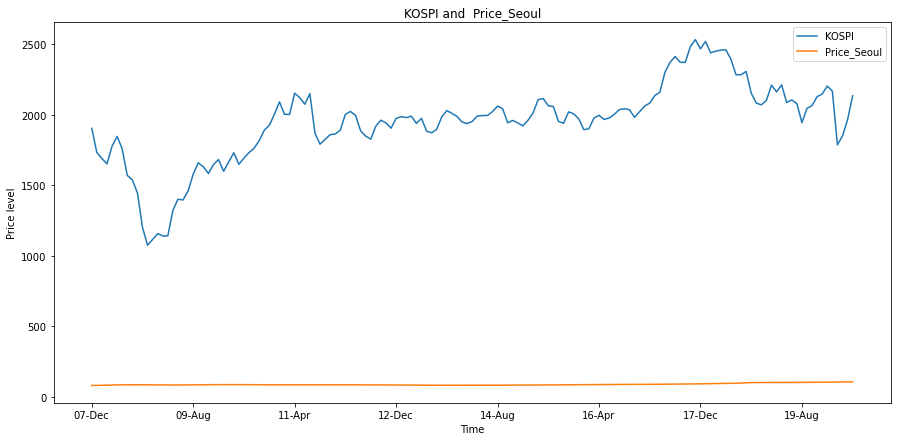

In [25]:
pd.concat([data[tickers[0]], data[tickers[1]]], axis=1).plot(figsize=(15,7))
plt.ylabel('Price level');
plt.xlabel('Time');
title = tickers[0] + ' and  ' + tickers[1]
plt.title(title)

Text(0.5, 1.0, 'KOSPI and  Price_Seoul')

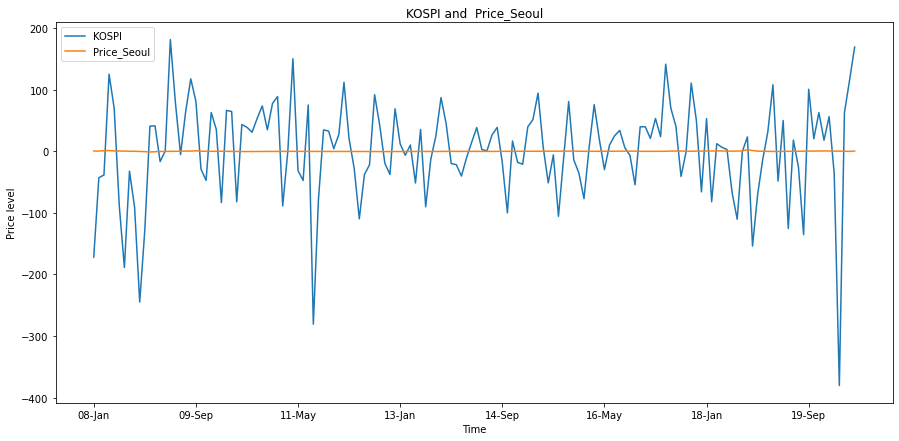

In [26]:
pd.concat([data_diff[tickers[0]], data_diff[tickers[1]]], axis=1).plot(figsize=(15,7))
plt.ylabel('Price level');
plt.xlabel('Time');
title = tickers[0] + ' and  ' + tickers[1]
plt.title(title)

<span style = "font-size:2em; font-weight:bolder"> Cointegration test </span>

In [30]:
data = pd.read_csv("https://raw.githubusercontent.com/myungjun-kim-beep/econ2005/master/team-project/2020-1%EC%A1%B0-Stock%20market%20and%20Housing%20market/Rawdata.txt",index_col='Month',sep='\s+',nrows=246)
data = data[["Price_Seoul","Sentiment"]]
y = data['Sentiment']
c = data['Price_Seoul']

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')


# Model 3 (2 lag-difference used = 3 lags VAR or VAR(3) model)
# with constant/trend (deterministc) term
joh_model3 = coint_johansen(data,0,2) # k_ar_diff +1 = K
joh_output(joh_model3)

# Model 2: with linear trend only
joh_model2 = coint_johansen(data,1,2) # k_ar_diff +1 = K
joh_output(joh_model2)

# Model 1: no constant/trend (deterministc) term
joh_model1 = coint_johansen(data,-1,2) # k_ar_diff +1 = K
joh_output(joh_model1)

   max_eig_stat  trace_stat
0     12.268551   15.154265
1      2.885714    2.885714 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

   max_eig_stat  trace_stat
0     13.628014   13.628166
1      0.000151    0.000151 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[15.0006 17.1481 21.7465]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[16.1619 18.3985 23.1485]
 [ 2.7055  3.8415  6.6349]] 

   max_eig_stat  trace_stat
0     13.509790   16.269834
1      2.760044    2.760044 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 



<span style = "font-size:2em; font-weight:bolder"> Granger Causality </span>

In [28]:
data_diff.head()

,KOSPI,Price_Seoul,Homeloan,Call_rate,M2,Export,Sentiment
Month,,,,,,,
08-Jan,-171.70,0.55,-35.7,0.00,16.9,-1.9,14.91
08-Feb,-42.76,0.53,-1139.1,-0.02,22.8,2.1,6.20
08-Mar,-38.38,1.15,99.4,0.00,14.8,0.1,15.42
08-Apr,125.43,1.33,841.4,0.02,15.4,0.8,-0.40
08-May,70.17,0.70,657.0,-0.02,17.2,1.0,-7.98


In [29]:
res = grangercausalitytests(data_diff[['Price_Seoul','Sentiment']],maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=48.3232 , p=0.0000  , df_denom=146, df_num=1
ssr based chi2 test:   chi2=49.3161 , p=0.0000  , df=1
likelihood ratio test: chi2=42.6015 , p=0.0000  , df=1
parameter F test:         F=48.3232 , p=0.0000  , df_denom=146, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=36.5710 , p=0.0000  , df_denom=143, df_num=2
ssr based chi2 test:   chi2=75.6994 , p=0.0000  , df=2
likelihood ratio test: chi2=61.1375 , p=0.0000  , df=2
parameter F test:         F=36.5710 , p=0.0000  , df_denom=143, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.6619 , p=0.0000  , df_denom=140, df_num=3
ssr based chi2 test:   chi2=74.5350 , p=0.0000  , df=3
likelihood ratio test: chi2=60.2917 , p=0.0000  , df=3
parameter F test:         F=23.6619 , p=0.0000  , df_denom=140, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=17.9821 , p=0.0000  